# Predicting Forest Fires Burn Area

### Shahla Eshraghi


## Introduction

Forest fires are a common occurance we hear in the news to regions like Australia and California. We thought being able to understand factors that impact the size of fires would be interesting to study considering these natural events happen so close to home. 

A team at the University of Minho, Portugal collected data on local fires in a Northeastern region of Portugul along with a variety of meterological data. We wanted to understand the following question: "How good is meteorological data at predicting how much area (1 hm2) the fire consumes?

In order to answer those questions, we created different types of regression models (Linear Regression, Decision Tree model, SVR, and Random Forest) and applied certain tools (gridsearch, Lasso, and Ridge) to improve model performance.


# Requirements

The following libraries need to be imported before running the program code. Please note that we surpressed warnings for clean readability of each output. Warning messages shown before supression indicated a change of function name/arguement, but does not interfere with the process. Lastly, the dataset is a csv file downloaded from UCI directory.

In [1]:
%matplotlib inline
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

warnings.filterwarnings('ignore')

# we renamed the downloaded csv file to "forestfires_100"
df=pd.read_csv('forestfires_100.csv')


## Data Visualization

Preparation work had to be done first to understand the data we are working with to understand patterns and correlations. Also to determine if we need to transform and manipulate the data.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       506 non-null    int64  
 1   Y       506 non-null    int64  
 2   month   506 non-null    object 
 3   day     506 non-null    object 
 4   FFMC    506 non-null    float64
 5   DMC     506 non-null    float64
 6   DC      506 non-null    float64
 7   ISI     506 non-null    float64
 8   temp    506 non-null    float64
 9   RH      506 non-null    int64  
 10  wind    506 non-null    float64
 11  rain    506 non-null    float64
 12  area    506 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 51.5+ KB


In [3]:
print(df.shape)

(506, 13)


In [4]:
df["FFMC"] = df["FFMC"].astype(int)
df["DMC"] = df["DMC"].astype(int)
df["DC"] = df["DC"].astype(int)
df["ISI"] = df["ISI"].astype(int)
df["temp"] = df["temp"].astype(int)
df["wind"] = df["wind"].astype(int)
df["rain"] = df["rain"].astype(int)
df["area"] = df["area"].astype(int)

In order to create a model, we needed to change all the data types to an integer.

In [5]:
print(df.dtypes)

X         int64
Y         int64
month    object
day      object
FFMC      int32
DMC       int32
DC        int32
ISI       int32
temp      int32
RH        int64
wind      int32
rain      int32
area      int32
dtype: object


In [6]:
#Checking for null values.
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [7]:
#Statistical description of our target variable.
print(df['area'].describe())

count    506.000000
mean       6.069170
std       13.733862
min        0.000000
25%        0.000000
50%        0.000000
75%        6.000000
max       95.000000
Name: area, dtype: float64


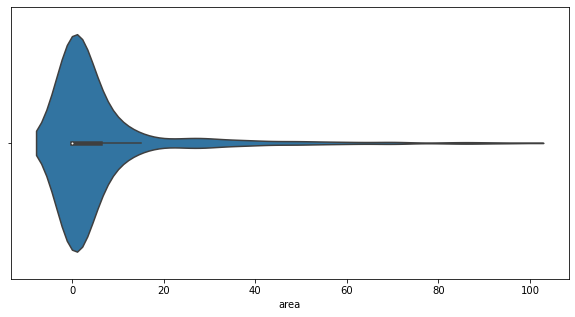

In [8]:
#Violin Plot
plt.figure(figsize = (10,5))
ax= sns.violinplot(df['area'])
plt.show()

We can see that most of the forest fire in our dataset are relatively small. 
As a lot of area data was equal to 0, we can convert this data to a binary variable, in order know if a fire took place, area equal to 1, or not, area equal to 0.

In [9]:
dfc=df.copy(deep=True) #We create a copy of the dataset to prevent from chaning the data used for the models
for i in dfc.index:
    if (dfc["area"][i]!=0):
        dfc["area"][i]=1      

In [10]:
#frequency distribution for fire happening
pd.crosstab(index=dfc['area'], columns='count')

col_0,count
area,
0,274
1,232


After converting the target variable to number, we see that in our dataset, 274 (56%) instances resulted in no fire while 232 (44%) instances resulted in a fire.

In [11]:
#Values description for temperature

print(dfc['temp'].describe())

count    506.000000
mean      18.353755
std        5.821040
min        2.000000
25%       15.000000
50%       19.000000
75%       22.000000
max       33.000000
Name: temp, dtype: float64


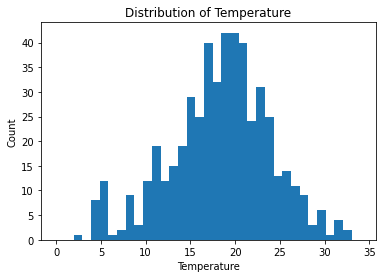

In [12]:
#bar diagram for temperature
plt.hist(dfc['temp'], bins=35, range=[0,34])
plt.title('Distribution of Temperature')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.show()

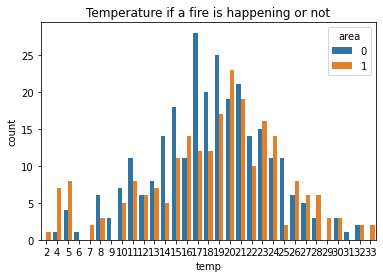

In [13]:
dfc["temp"] = dfc["temp"].astype(int)
ax = sns.countplot('temp',hue='area', data=dfc)
ax.set_title('Temperature if a fire is happening or not') #if area = 1, a fire took place
ax.set_xlabel('temp')
ax.set_ylabel('count')
plt.show()

In [14]:
#numerical summary for temperature
dfc.groupby('area')['temp'].describe()

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
0,274.0,18.240876,5.279757,4.0,15.0,18.0,22.0,32.0
1,232.0,18.487069,6.410881,2.0,15.0,19.0,23.0,33.0


We can therefore see that Temperature does not have a big influence on fire happening, since there are more fire happening for low temperatures than high temperatures.

In [15]:
#frequency distribution for Relative Humidity
pd.crosstab(index=dfc['RH'], columns='count')

col_0,count
RH,
15,2
17,1
18,1
19,4
20,1
...,...
94,1
96,1
97,1


In [16]:
#Values description for RH

print(dfc['RH'].describe())

count    506.000000
mean      44.420949
std       16.414998
min       15.000000
25%       33.000000
50%       42.000000
75%       53.750000
max      100.000000
Name: RH, dtype: float64


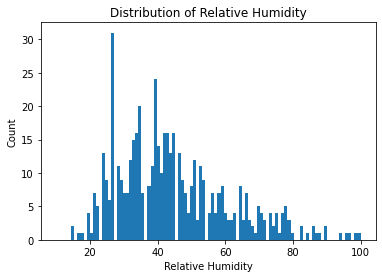

In [17]:
#bar diagram for RH
plt.hist(dfc['RH'], bins=100, range=[10,100])
plt.title('Distribution of Relative Humidity')
plt.xlabel('Relative Humidity')
plt.ylabel('Count')
plt.show()

Relative humidity was quite low most of the time.

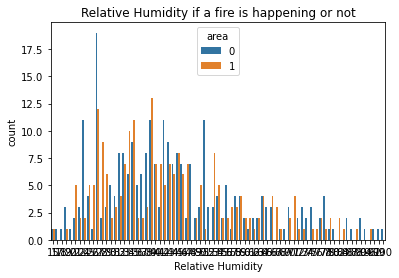

In [18]:
dfc["RH"] = dfc["RH"].astype(int)
ax = sns.countplot('RH',hue='area', data=dfc)
ax.set_title('Relative Humidity if a fire is happening or not') #if area = 1, a fire took place
ax.set_xlabel('Relative Humidity')
ax.set_ylabel('count')
plt.show()

More forestfires are happening when the relative humidity is low.

In [19]:
#frequency distribution for Wind
pd.crosstab(index=dfc['wind'], columns='count')

col_0,count
wind,
0,14
1,44
2,94
3,91
4,136
5,64
6,27
7,18
8,14


In [20]:
#Values distribution for Wind

print(dfc['wind'].describe())

count    506.000000
mean       3.567194
std        1.807693
min        0.000000
25%        2.000000
50%        4.000000
75%        4.750000
max        9.000000
Name: wind, dtype: float64


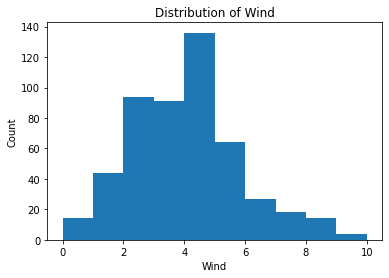

In [21]:
#bar diagram for Wind
plt.hist(dfc['wind'], bins=10, range=[0,10])
plt.title('Distribution of Wind')
plt.xlabel('Wind')
plt.ylabel('Count')
plt.show()

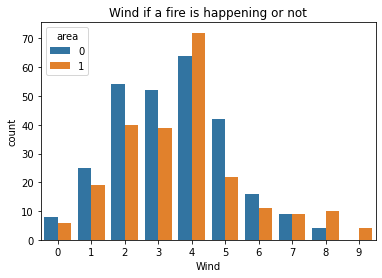

In [22]:
dfc["wind"] = dfc["wind"].astype(int)
ax = sns.countplot('wind',hue='area', data=dfc)
ax.set_title('Wind if a fire is happening or not') #if area = 1, a fire took place
ax.set_xlabel('Wind')
ax.set_ylabel('count')
plt.show()

There are more fire happening when the wind is high.

In [23]:
#frequency distribution for rain
pd.crosstab(index=dfc['rain'], columns='count')

col_0,count
rain,
0,503
1,2
6,1


In [24]:
#Values description for Rain

print(dfc['rain'].describe())

count    506.000000
mean       0.015810
std        0.273856
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: rain, dtype: float64


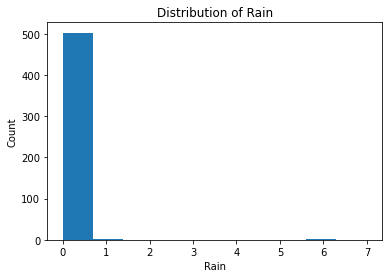

In [25]:
#bar diagram for Rain
plt.hist(dfc['rain'], bins=10, range=[0,7])
plt.title('Distribution of Rain')
plt.xlabel('Rain')
plt.ylabel('Count')
plt.show()

There has been no rain for most of the time.

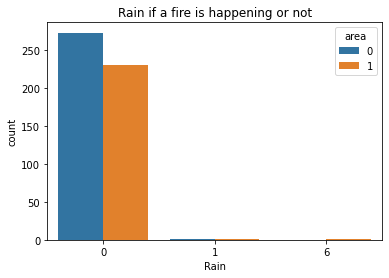

In [26]:
dfc["rain"] = dfc["rain"].astype(int)
ax = sns.countplot('rain',hue='area', data=dfc)
ax.set_title('Rain if a fire is happening or not') #if area = 1, a fire took place
ax.set_xlabel('Rain')
ax.set_ylabel('count')
plt.show()

Rain equal 0 wether there has been a fire or not, but most of the time, there were no fire when rain didn't occur. Moreover, there has been fires when rain occured. We can then conclude rain does not really have an influence on fire appearance.

## Correlation plot

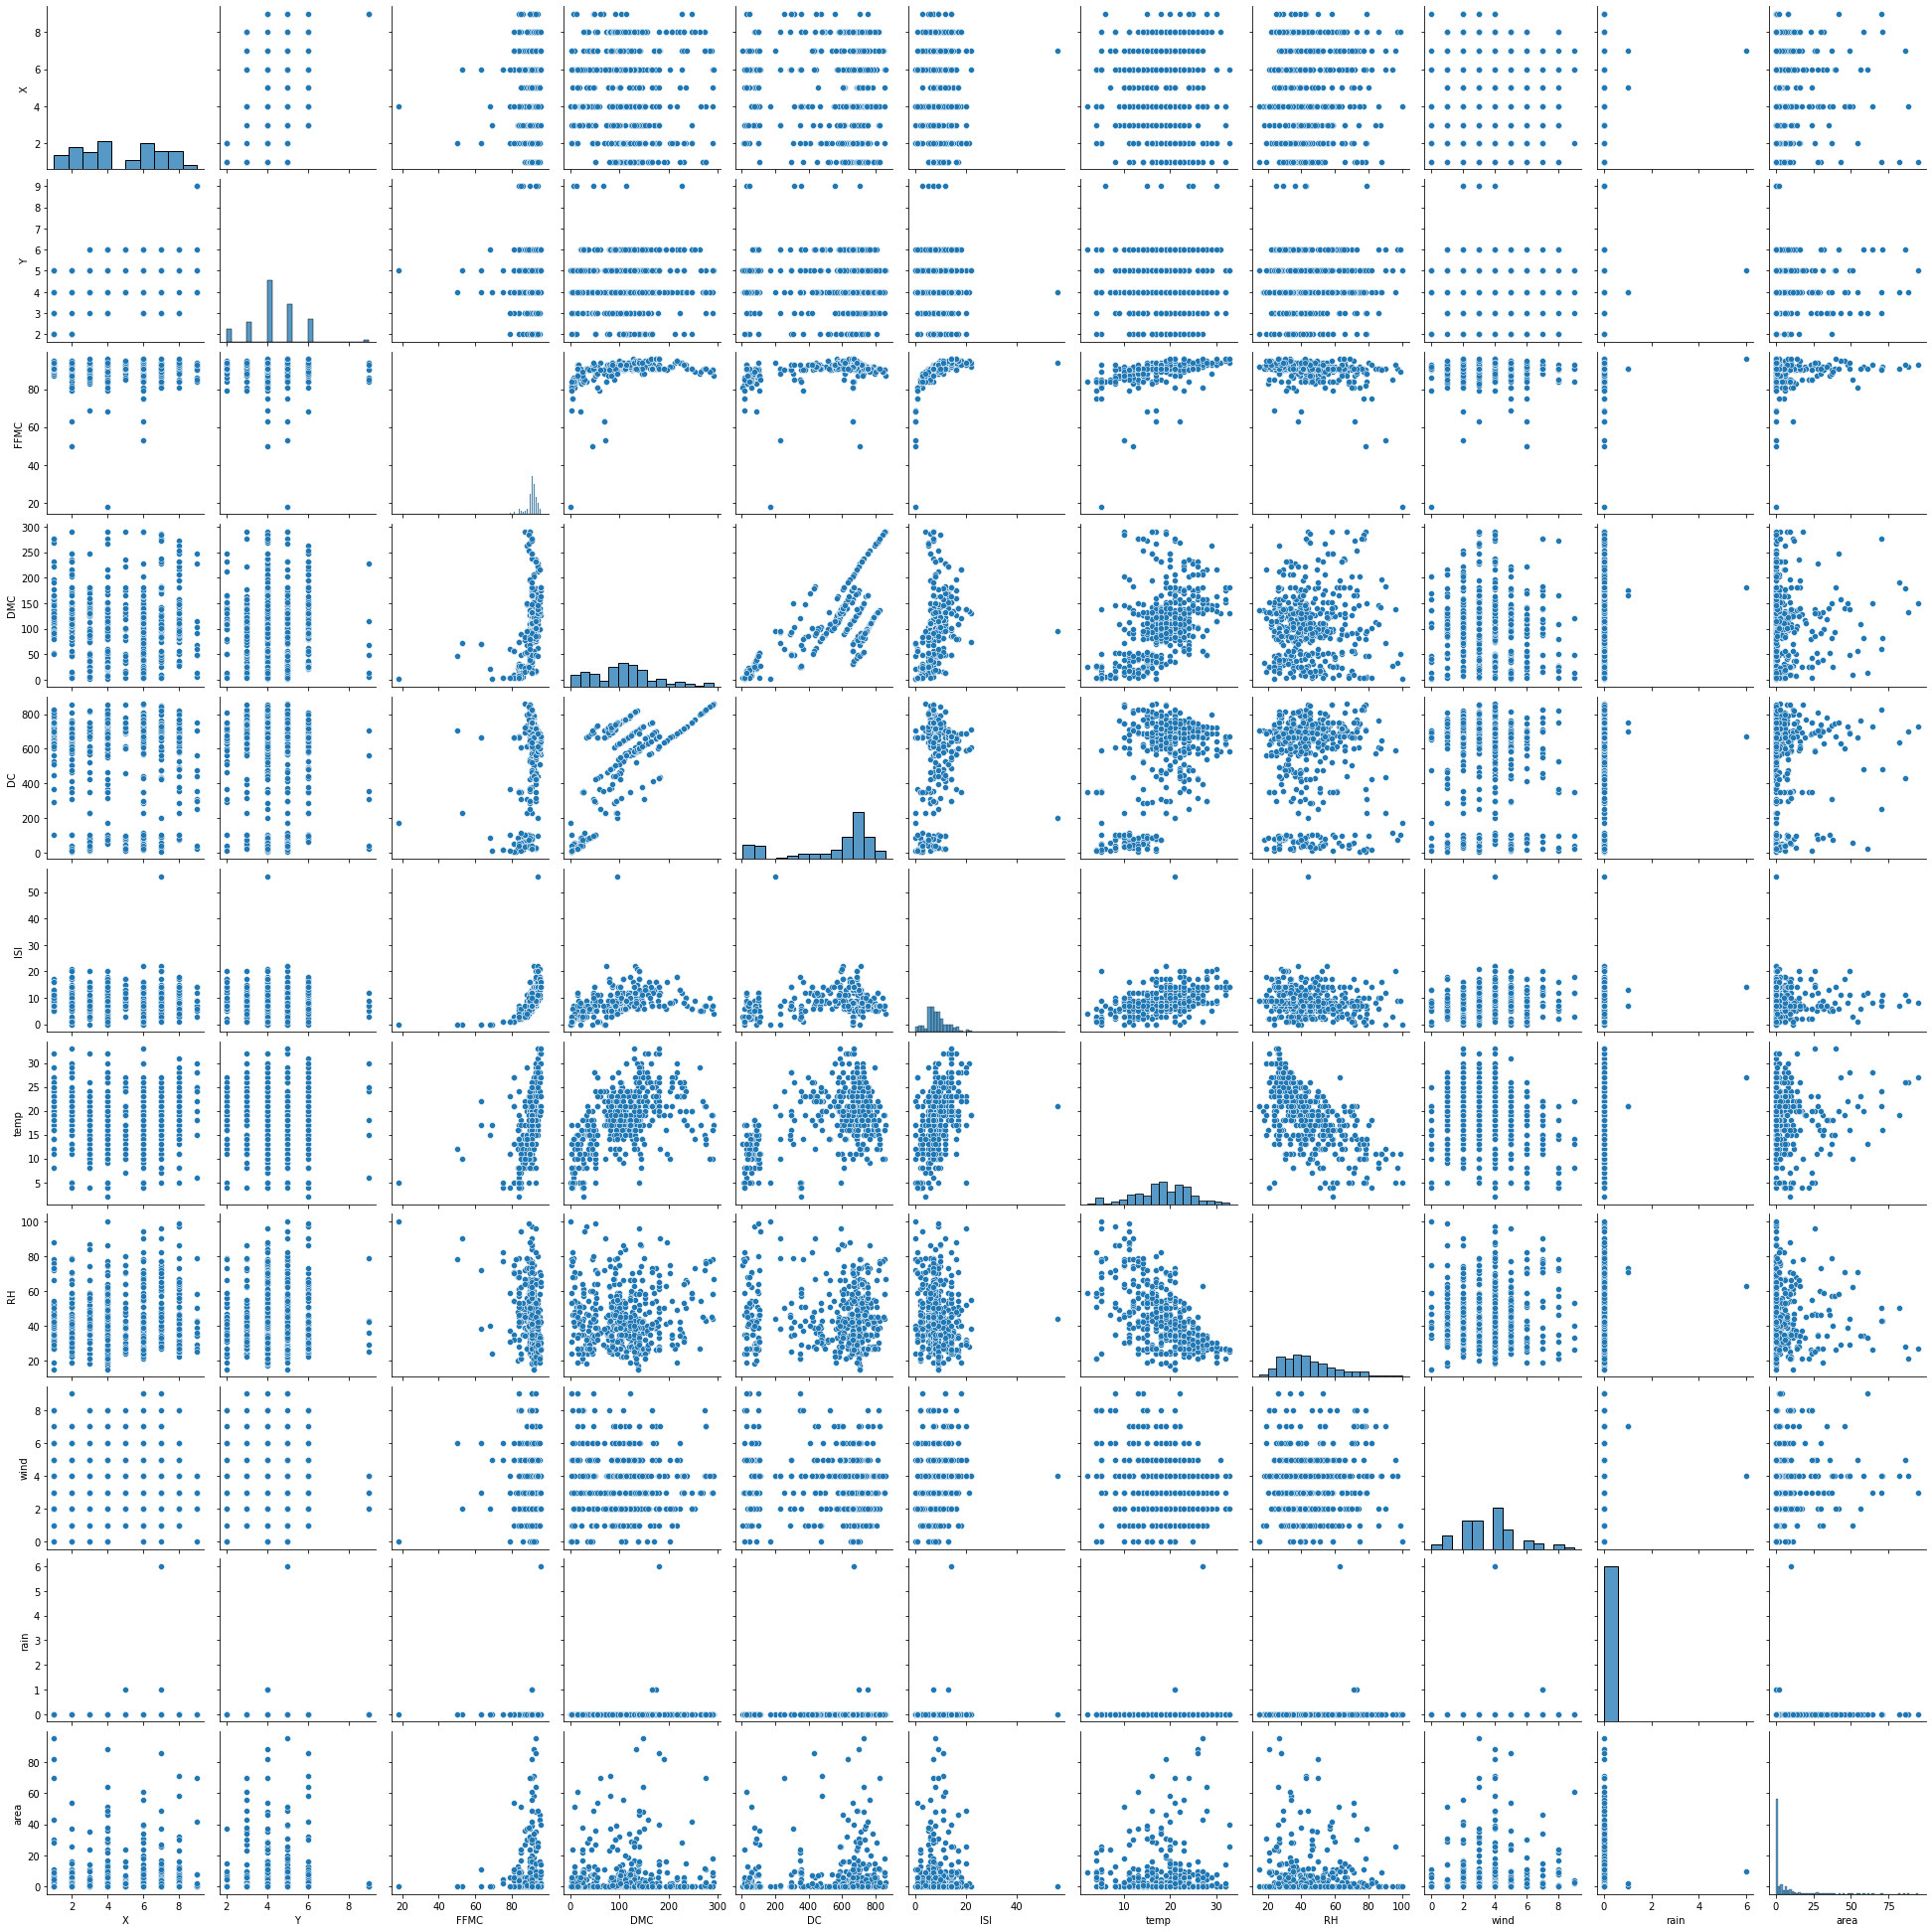

In [27]:
#Correlogram
sns.pairplot(df)
plt.show()

<AxesSubplot:>

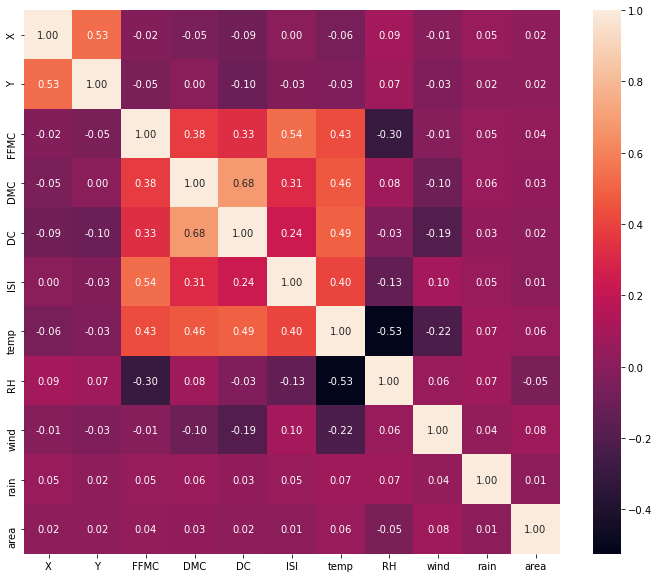

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),annot=True,fmt='.2f')

Looking at the correlation plot, we see that no features correlate to our target variable "area"

# Dataset Preparation

After understanding our data, we are ready to start building our models. 

We dropped two categorical features "X" and "Y". These spatial data points had no bearing on the target variable and showed location of each fire, which is out of scope for this project. In addition we dropped "month" and "day", as these features complicated the model and was out of scope for the project. 

The dataset contained no null values. Lastly, we changed all features that remained to integer datatype from float64 to allow our models to run properly.

The new dataframe created was assigned to df_new and used for X and Y variables. We eventually applied feature removal and had to created a new dataset called df_features. This dataframe was used for X1 and Y1 variables. 

In this workbook, SVR, Decision Tree, and Random Forest models are using df_features for the best performance possible.

In [29]:
#Feature removal
#4,5,7 ISI, temp, wind
df_new = df.drop(["X","Y","month","day"], axis=1).astype(np.int)
df_features = df.drop(["X","Y","RH","month","day","FFMC","DMC","DC"], axis=1).astype(np.int)

x1 = df_features.drop(["area"], axis=1)
y1 = df_features[["area"]]

print("df_features: ",df_features.columns)
print("x1: ",x1.columns)
print("y1: ",y1.columns) 

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=4)

df_features:  Index(['ISI', 'temp', 'wind', 'rain', 'area'], dtype='object')
x1:  Index(['ISI', 'temp', 'wind', 'rain'], dtype='object')
y1:  Index(['area'], dtype='object')


# Linear Regression

For our first model, we createa a linear regression using "wind" feature on our target variable. Looking at the model performance (MSE and r2), we see this model is not a good fit.

In [30]:
# creating an instance of LinearRegression class
x = df['wind']
y = df["area"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

reg = linear_model.LinearRegression()
print(reg)

LinearRegression()


In [31]:
print(y_train.shape) 
y_train = y_train[:,None] # y_train = y_train.reshape(-1, 1)
print(y_train.shape)
x_train = x_train[:,None]
print(x_train.shape)
x_test = x_test[:,None]
y_test = y_test[:,None]

(404,)
(404, 1)
(404, 1)


In [32]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [33]:
# y = mx + b here m is the coefficient (or slope) of x and b is the intercept
reg.fit(x_train, y_train)
print(reg.coef_) # 
print(reg.intercept_)

[[0.68643276]]
[3.65135368]


In [34]:
# area = 0.21390022 wind + 2.14145839

In [35]:
yhat = reg.predict(x_test)

In [36]:
print(yhat[0])

[7.08351747]


In [37]:
mse_test = mean_squared_error(y_test, yhat)
print(mse_test)

159.7243607929214


In [38]:
# y_t_predict is the predicted y values for the x_train data
y_t_predict = reg.predict(x_train)

# note that y_train is the true y value
mse_train = mean_squared_error(y_train, y_t_predict)
mse_test = mean_squared_error(y_test, yhat)
print("mse_train :",mse_train)
print("mse_test :",mse_test)
print("r2_train :", r2_score(y_train, y_t_predict))
print("r2_test: ", r2_score(y_test, yhat))

mse_train : 193.9302564117646
mse_test : 159.7243607929214
r2_train : 0.008152098228848992
r2_test:  -0.0019144190478788126


In [39]:
r1= mse_test/mse_train
diff1=np.abs(mse_train - mse_test)

print("r1: ", r1)
print("diff1: ",diff1)

r1:  0.8236175403892875
diff1:  34.205895618843186


# Lasso Regression

For our second model, we ran a Lasso Regression to minimize the impact of unimportant features. After looking at the performance, this model was not a good fit.

In [40]:
x = df_new.drop("area", axis=1)
y = df_new[["area"]]
print(x.columns)

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], dtype='object')


In [41]:
lassoReg = Lasso(alpha=0.05 ,  normalize=False)

lassoReg.fit(x1_train,y1_train)

y_test_pred = lassoReg.predict(x1_test)
y_train_pred = lassoReg.predict(x1_train)


mse_test = mean_squared_error(y1_test, y_test_pred)

mse_train = mean_squared_error(y1_train, y_train_pred)

print("mse_train: ", mse_train)
print("mse_test: ", mse_test)

r2_lasso_train = r2_score(y1_train, y_train_pred)
r2_lasso_test = r2_score(y1_test, y_test_pred)

print("r2_lasso_train: ", r2_lasso_train)
print("r2_lasso_test: ", r2_lasso_test)


mse_train:  190.5523320227819
mse_test:  167.84688468826647
r2_lasso_train:  0.025428346296300308
r2_lasso_test:  -0.05286515548787607


# Ridge Regression

For our third model, we ran a Ridge Regression to minimize the impact of unimportant features. After looking at the performance, this model was not a good fit.

In [42]:
print("LassoReg.coef: ",lassoReg.coef_)
print("LassoReg.intercept: ",lassoReg.intercept_)

LassoReg.coef:  [-0.23580936  0.35204468  0.96152176 -0.        ]
LassoReg.intercept:  [-1.76872978]


In [43]:
ridgeReg = Ridge(alpha=3, normalize=False)

ridgeReg.fit(x1_train,y1_train)

y_train_pred = ridgeReg.predict(x1_train)
y_test_pred = ridgeReg.predict(x1_test)

mse_test = mean_squared_error(y1_test, y_test_pred)
mse_train = mean_squared_error(y1_train, y_train_pred)

r2_ridge_train = r2_score(y1_train, y_train_pred)
r2_ridge_test = r2_score(y1_test, y_test_pred)

print("mse_train: ", mse_train)
print("mse_test: ", mse_test)

print("r2_ridge_train: ", r2_ridge_train)
print("r2_ridge_test: ", r2_ridge_test)

mse_train:  190.5467914700477
mse_test:  168.03971222577624
r2_ridge_train:  0.025456683213425868
r2_ridge_test:  -0.05407471857056079


# Feature Removal

We used the coefficients from lasso and ridge regressions to determine which features should be removed from the dataset. We concluded that the new dataset should only contain 'ISI', 'temp', 'wind', 'rain' based on highest coefficient values and removing values equal to 0.

See Data Preparation section above for the new dataset variables referenced.

In [44]:
print("ridgeReg.coef: ",ridgeReg.coef_)
print("ridgeReg.intercept: ",ridgeReg.intercept_)

ridgeReg.coef:  [[-0.24023873  0.35697354  0.97985847 -0.19548414]]
ridgeReg.intercept:  [-1.88219329]


In [45]:
print("LassoReg.coef: ",lassoReg.coef_)
print("LassoReg.intercept: ",lassoReg.intercept_)

LassoReg.coef:  [-0.23580936  0.35204468  0.96152176 -0.        ]
LassoReg.intercept:  [-1.76872978]


# Hyperparameters

In [46]:
lassoTestlow = Lasso(alpha=0.1, normalize = False)
lassoTestmed = Lasso(alpha=0.15, normalize = False)
lassoTesthigh = Lasso(alpha=0.2, normalize = False)

lassoTestlow.fit(x_train,y_train)
lassoTestmed.fit(x_train,y_train)
lassoTesthigh.fit(x_train,y_train)

x_Lasso = [0.1, 0.15, 0.2]
y_Lasso = [lassoTestlow.coef_, lassoTestmed.coef_, lassoTesthigh.coef_]

print("++++++++++ Lasso ++++++++++")

print("for alpha=0.1: ", y_Lasso[0])
print("for alpha=0.15: ",y_Lasso[1])
print("for alpha=0.2: ", y_Lasso[2])



ridgeTestlow = Ridge(alpha=0.1, normalize = False)
ridgeTestmed = Ridge(alpha=0.15, normalize = False)
ridgeTesthigh = Ridge(alpha=0.2, normalize = False)

ridgeTestlow.fit(x_train,y_train)
ridgeTestmed.fit(x_train,y_train)
ridgeTesthigh.fit(x_train,y_train)

x_Ridge = [0.1, 0.15, 0.2]
y_Ridge = [ridgeTestlow.coef_, ridgeTestmed.coef_, ridgeTesthigh.coef_]

print("\n++++++++++ Ridge ++++++++++")
print("for alpha=0.1: ", y_Ridge[0])
print("for alpha=0.15: ",y_Ridge[1])
print("for alpha=0.2: ", y_Ridge[2])


++++++++++ Lasso ++++++++++
for alpha=0.1:  [0.65687128]
for alpha=0.15:  [0.64209054]
for alpha=0.2:  [0.62730981]

++++++++++ Ridge ++++++++++
for alpha=0.1:  [[0.68638253]]
for alpha=0.15:  [[0.68635742]]
for alpha=0.2:  [[0.68633232]]


# Decision Tree

Now using the new dataset with removed features, we ran the decision tree as our fourth model. We applied gridsearchCV to determine the optimal # of trees and random_state for the best performance. After considering the MSE and r2 values on the test/train data, we found a model with strong performance.

mse_train: 31.65
mse_test: 305.22
r2_train: 0.83
r2_test: -0.91

In [47]:
'''
model = DecisionTreeRegressor()

max_depth = [3,4,5,20]
random_state= [0,1,2,3,4]

grid = dict(max_depth=max_depth,random_state=random_state)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3)
grid_result = grid_search.fit(x1_train, np.ravel(y1_train))

print("\nGridSearhCV best model:\n ")
print('The best score: ', grid_result.best_score_)
print('The best parameters:', grid_result.best_params_)
'''

'\nmodel = DecisionTreeRegressor()\n\nmax_depth = [3,4,5,20]\nrandom_state= [0,1,2,3,4]\n\ngrid = dict(max_depth=max_depth,random_state=random_state)\ngrid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3)\ngrid_result = grid_search.fit(x1_train, np.ravel(y1_train))\n\nprint("\nGridSearhCV best model:\n ")\nprint(\'The best score: \', grid_result.best_score_)\nprint(\'The best parameters:\', grid_result.best_params_)\n'

Using gridsearchCV, the output states the best parameters to use is max_depth = 3 and random_state = 0. However for the sake of validation, we tried different numbers for these parameters and determined that max_depth = 20 produces the best performance for the model.

In [48]:
tree = DecisionTreeRegressor(max_depth=20 , random_state = 0)
cross_val_score(tree, x1, y1, cv=10)
tree.fit(x1_train, y1_train)

y_train_pred = tree.predict(x1_train)
y_test_pred = tree.predict(x1_test)

mse_test = mean_squared_error(y1_test, y_test_pred)
mse_train = mean_squared_error(y1_train, y_train_pred)

print("mse_train: ", mse_train)
print("mse_test: ", mse_test)

r2_train = r2_score(y1_train, y_train_pred)
r2_test = r2_score(y1_test,y_test_pred) # returns the r-squared value

print("r2_train: ", r2_train)
print("r2_test: ", r2_test)

mse_train:  31.65338283828383
mse_test:  305.2222331154684
r2_train:  0.8381101436515905
r2_test:  -0.9145893266015397


In [49]:
r1 = mse_test/mse_train
diff1 = np.abs(mse_train - mse_test)
print("r1: ",r1)
print("diff1: ",diff1)

r1:  9.64264182046006
diff1:  273.56885027718454


# Random Forest

We wanted to see if Random Forest Regression would yield similar results to the decision tree. As our fifth model, we ran this model and optimized for the # of trees and random_state. This model also yielded good performance for the dataset.

mse_train: 62.76
mse_test: 63.52
r2_train: 0.67
r2_test: 0.60

In [50]:
#x, y = make_regression(n_features=8, n_informative=2,random_state=0, shuffle=False)
rfc = RandomForestRegressor(n_estimators = 100, max_depth=15, random_state=2)
rfc.fit(x1, y1)

RandomForestRegressor(max_depth=15, random_state=2)

In [51]:
y_hat = rfc.predict(x1_train)
y_pred = rfc.predict(x1_test)

mse_test = mean_squared_error(y1_test, y_pred)
mse_train = mean_squared_error(y1_train, y_hat)
print("mse_train: ", mse_train)
print("mse_test: ", mse_test)

r2_train = r2_score(y1_train, y_hat)
r2_test = r2_score(y1_test,y_pred) 
print("r2_train: ", r2_train)
print("r2_test: ", r2_test)


mse_train:  62.76493716334995
mse_test:  63.526004221072945
r2_train:  0.6789914457799364
r2_test:  0.6015158908908897


In [52]:
r1= mse_test/mse_train
diff1=np.abs(mse_train - mse_test)

print("r1: ",r1)
print("diff1: ",diff1)

r1:  1.0121256722641538
diff1:  0.7610670577229968


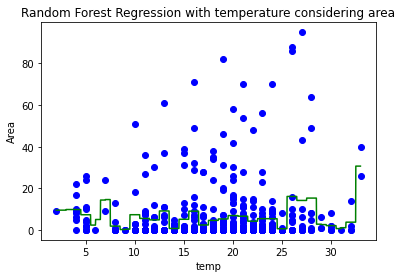

In [53]:
xp = df_new.iloc[:, 4:5].values #as shown with the print, selects the 4th/temperature column
yp = df_new.iloc[:, 8].values #as shown with the print, selects the 8th/area column

# fit the regressor with x and y data 
rfc.fit(xp, yp)

Y_pred = rfc.predict(np.array([6.5]).reshape(1, 1))

# Visualising the Random Forest Regression results

# arange for creating a range of values from min value of x to max value of x 
#with a difference of 0.01 between two consecutive values 
X_grid = np.arange(min(xp), max(xp), 0.01)

# reshape for reshaping the data into a len(X_grid)*1 array, i.e. to make a column out of the X_grid value 
X_grid = X_grid.reshape((len(X_grid), 1))

# Scatter plot for original data 
plt.scatter(xp, yp, color = 'blue')


# plot predicted data 
plt.plot(X_grid, rfc.predict(X_grid), 
 color = 'green') 
plt.title('Random Forest Regression with temperature considering area') 
plt.xlabel('temp') 
plt.ylabel('Area') 
plt.show()

We graphed the Random Forest model to see how well it predicted the data points.

## SVR using GridsearchCV

We decided to run SVR model as well since we had strong model performance for Decision Tree and Random Forest. However it did not yield good results.

Evaluate the current algorithm and variety of algorithms by creating test harness for diverse algorithms in conjunction with resampling techniques like cross validation, variable importance and implementing Gridsearch.Improve Result by playing with hyperparameters and innovative methods like ensembles.

In [54]:
parameters = {'kernel':['linear', 'rbf', 'poly'], 'C':[1, 5, 10]}

s = SVR()

clf = GridSearchCV(s, param_grid = parameters, cv = 3, verbose=True, n_jobs=-1)

final_clf = clf.fit(x1_train, y1_train)


#print(sorted(final_clf.cv_results_.keys()))
print("Best parameters: ",final_clf.best_estimator_)
print(sorted(final_clf.cv_results_.keys()))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters:  SVR(C=10)
['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']


In [55]:
#Create SVR
svregressor = SVR(kernel='linear', C=10) 

#Train the model
svregressor.fit(x1_train, y1_train) 

yhat = svregressor.predict(x1_test)
y_pred = svregressor.predict(x1_train)

In [56]:
yhat = svregressor.predict(x1_test)
mse_test = mean_squared_error(y1_test, yhat)
y_t_predict = svregressor.predict(x1_train)
yhat = svregressor.predict(x1_test)

mse_train = mean_squared_error(y1_train, y_pred)
print("mse_train: ",mse_train)
print("mse_test: ",mse_test)

print("r-squared for test data: ", r2_score(y1_test, yhat))
print("r-squared for train data: ", r2_score(y1_train, y_t_predict))

mse_train:  230.96766611148053
mse_test:  194.80719532514667
r-squared for test data:  -0.22198102381882157
r-squared for train data:  -0.1812741304443224


In [57]:
r1 = mse_test/mse_train

diff1 = np.abs(mse_train - mse_test)

print("r1: ",r1)

print("diff1: ",diff1)

r1:  0.8434392510643443
diff1:  36.16047078633386


# Conclusion
The best performing one was Random Forest Regressor. While Decision tree also yielded strong performance, we think Random Forest is better for the following reasons:

1. Random forest shows a moderately strong r2 value for both test train datasets. 

2. MSE for test and train is significantly lower than Decision Tree.

3. Random forest has high consistency for MSE and r2 while decision tree tends to fluctuate. We think a consistent,   moderately strong r2 value is better option over highest r2 value.


# References

- dataset : https://archive.ics.uci.edu/ml/datasets/Forest+Fires


- Random Forest plot: https://www.geeksforgeeks.org/random-forest-regression-in-python/


- More refrences: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html?highlight=decision%20tree%20regressor#sklearn.tree.DecisionTreeRegressor


